In [1]:

import os
import sys
import pickle
import warnings
import time
import logging
import glob

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from iminuit import Minuit
from matplotlib import ticker
from matplotlib.legend import Legend

from statsmodels.tsa.stattools import acf 
from statsmodels.graphics.tsaplots import plot_acf


from utils import *
from AnalyseDefects_dev import AnalyseDefects

plt.style.use('sg_article')

TODO:

- take into account that acf might fail at low act. Eg by discarding acf for tau < 5 or something in the crit region


In [2]:
def calc_acf_for_arr(arr, conv_idx = 0, nlags = 0, alpha = 0.05):
    """
    takes def arr with shape (Nframes, Nexp) and calculates the acf for each act and each exp 
    nlags = 0: calculate all lags
    """
    Nframes, Nexp = arr.shape
    nlags = Nframes - conv_idx if nlags == 0 else min(Nframes - conv_idx, nlags)

    acf_arr = np.nan * np.zeros((Nframes + 1, Nexp))
    confint_arr = np.nan * np.zeros((Nframes + 1, 2, Nexp))

    for i in range(Nexp):
        acf_res, confint = acf(arr[conv_idx:,i], nlags = nlags, alpha = alpha)
        acf_arr[-(nlags + 1):, i] = acf_res
        confint_arr[-(nlags + 1):, :, i] = confint

    return acf_arr, confint_arr

def estimate_effective_sample_size(acf_vals, acf_err_vals = None, confint_vals = None, 
                                   max_lag=None, max_lag_threshold=0, 
                                   simple_threshold = 0.1, use_abs_sum=False):
    """ acf_vals must not be non ie. start from steady state.
    if max_lag is None, the first lag where the confidence interval is below threshold is used.

    Returns the effective sample size N_eff, tau, tau_simple
    """
    N = acf_vals.shape[0]

    if max_lag is None:
        if acf_err_vals is None:
            val = confint_vals[:,0]
        else:
            val = acf_vals[:max_lag] - acf_err_vals[:max_lag]     
        try:
            max_lag = np.where(val < max_lag_threshold)[0][0]
            tau_simple = np.where(val < np.abs(simple_threshold))[0][0]
        except:
            return np.nan, np.nan, np.nan
  
    # Sum the autocorrelation values
    if use_abs_sum:
        tau = 1 + 2 * np.sum(np.abs(acf_vals[1:max_lag]))
    else:
        tau = 1 + 2 * np.sum(acf_vals[1:max_lag])
    
    # Effective sample size
    N_eff = N / tau
    return N_eff, tau, tau_simple


In [3]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    priority_vl = 2 if LL == 512 else 3
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = priority_vl, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 3 if priority_vl == 2 else 2, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256, 512] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

LL = 2048
output_path = f'data\\nematic_analysis{LL}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_list, output_path=output_path)

extract = False
analyze = False
merge = False

In [6]:
N = -1
def_arr = ad.get_arrays_full(Ndataset=N)[0]
kbins, sfac = ad.get_sfac_pcf(Ndataset=N, time_av=False)[:2]
act_list = ad.act_list[N]
conv_list = ad.conv_list[N] 
def_arr_series = pd.DataFrame(def_arr[:,N,0], columns=['defect_density'])
#pd.plotting.lag_plot(def_arr_series, lag=40);

In [ ]:
act = 0.022
act_idx = act_list.index(act)
alpha = 1 - 0.3413 * 2

conv_idx = conv_list[act_idx]
nf = def_arr.shape[0] - conv_idx
nlags = int(nf/2)

sfac_res = sfac[conv_idx:, :, act_idx, 0]
kmax_idx = 10

acf_sfac, confint_sfac = calc_acf_for_arr(sfac_res[:, :kmax_idx], nlags=nlags)
confint_arr_sym = np.abs(confint_sfac[:,1,:] - confint_sfac[:,0,:]) / 2

for i, k in enumerate(range(1, kmax_idx)):
    
    N_eff, tau = estimate_effective_sample_size(acf_sfac[-(nlags + 1):,i], acf_err_vals=None, confint_vals=confint_sfac[-(nlags + 1):, :, i], threshold=0.1,)
    print(f'kbins = {kbins[k]}, N_eff = {N_eff}, tau = {tau}')

acf_avg, confint_avg = calc_weighted_mean(acf_sfac[-(nlags + 1):,:], confint_arr_sym[-(nlags + 1):,:])
N_eff, tau = estimate_effective_sample_size(acf_avg, acf_err_vals=confint_avg, threshold=0.1,)
print(f'av of k, N_eff = {N_eff}, tau = {tau}')

plt.plot(acf_avg)
plt.fill_between(np.arange(acf_avg.shape[0]), acf_avg - confint_avg[:], acf_avg + confint_avg[:], alpha=0.5)

In [ ]:
ad.plot_defects_per_exp(Ndataset=-1, act_idx_bounds=[act_idx, act_idx+2])

In [5]:
temp_corr = ad.calc_corr_time(Ndataset=N, save=False)

c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


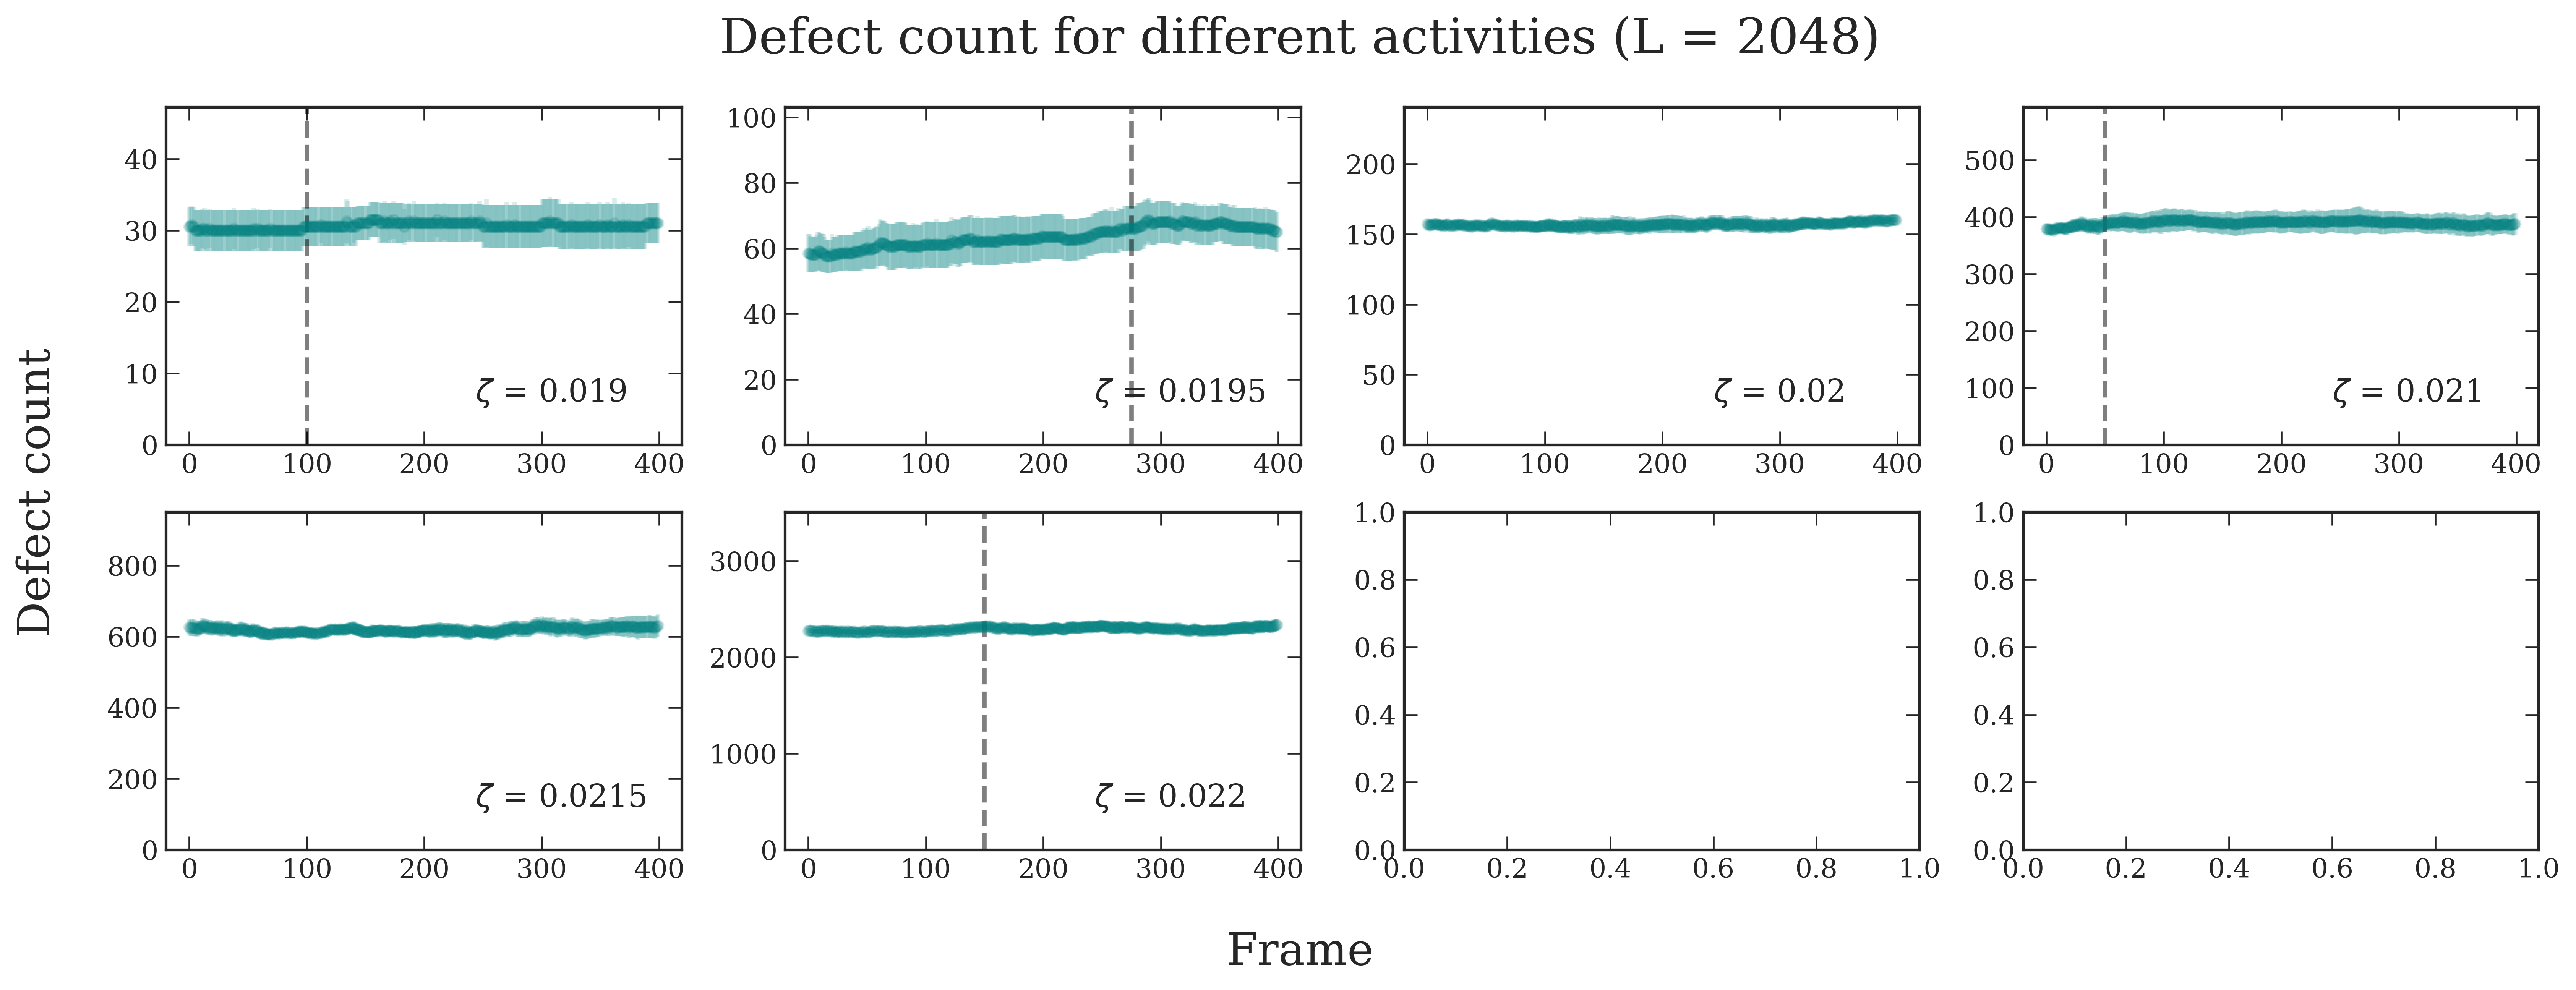

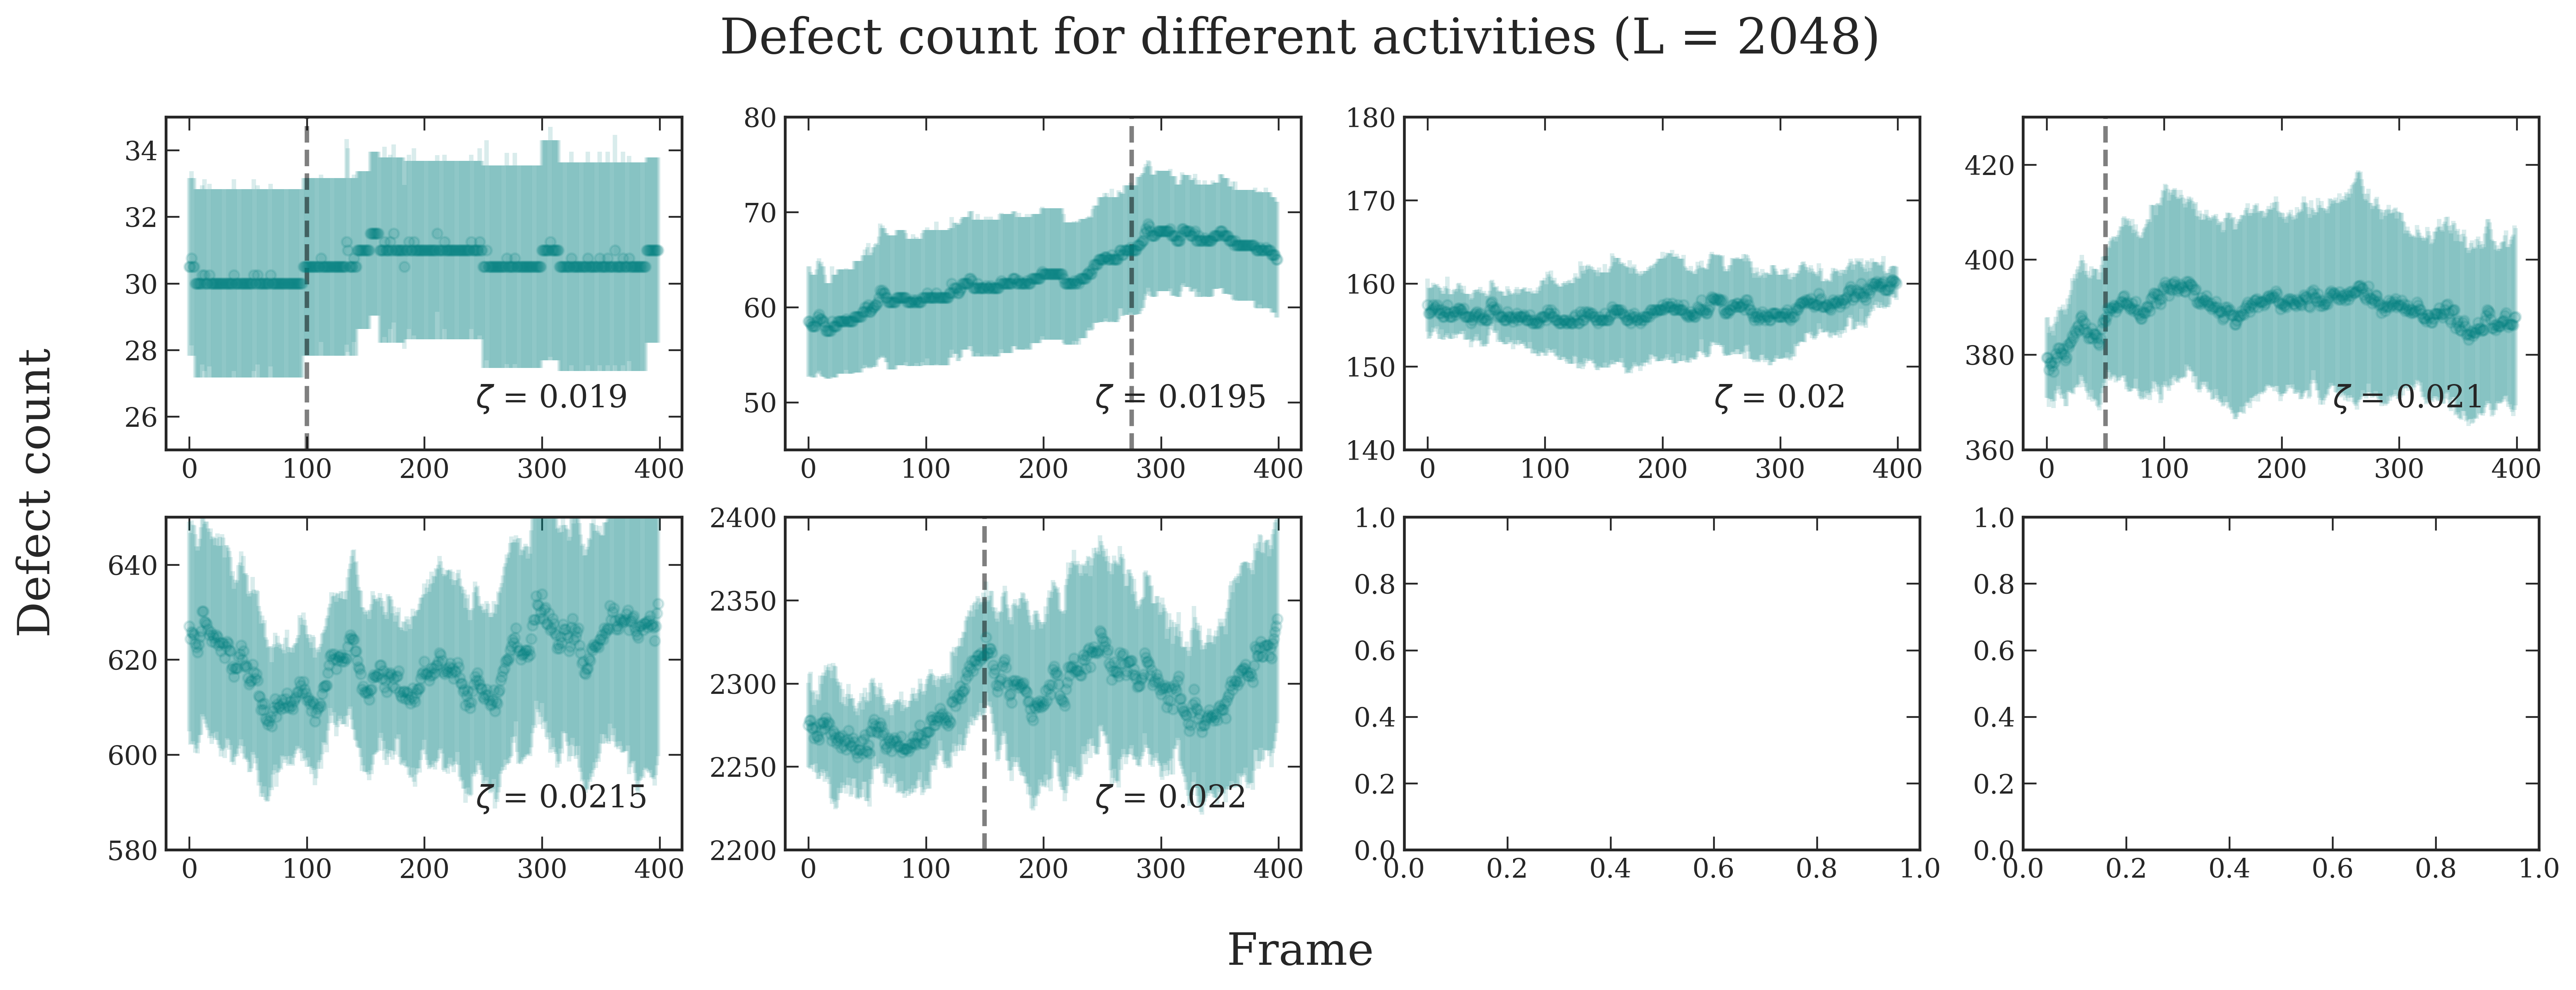

In [31]:
fig, ax = ad.plot_defects_per_activity(-1)
lim=[(25,35), (45,80), (140,180), (360,430), (580,650), (2200,2400)]
for i, axx in enumerate(ax[:len(lim)]):
    axx.set_ylim(lim[i])
fig

[53.36284314 59.75483277 63.37381608 35.34376548  0.          0.        ]
[81.71072359 79.84262126 90.73185269 49.37115516  0.          0.        ]


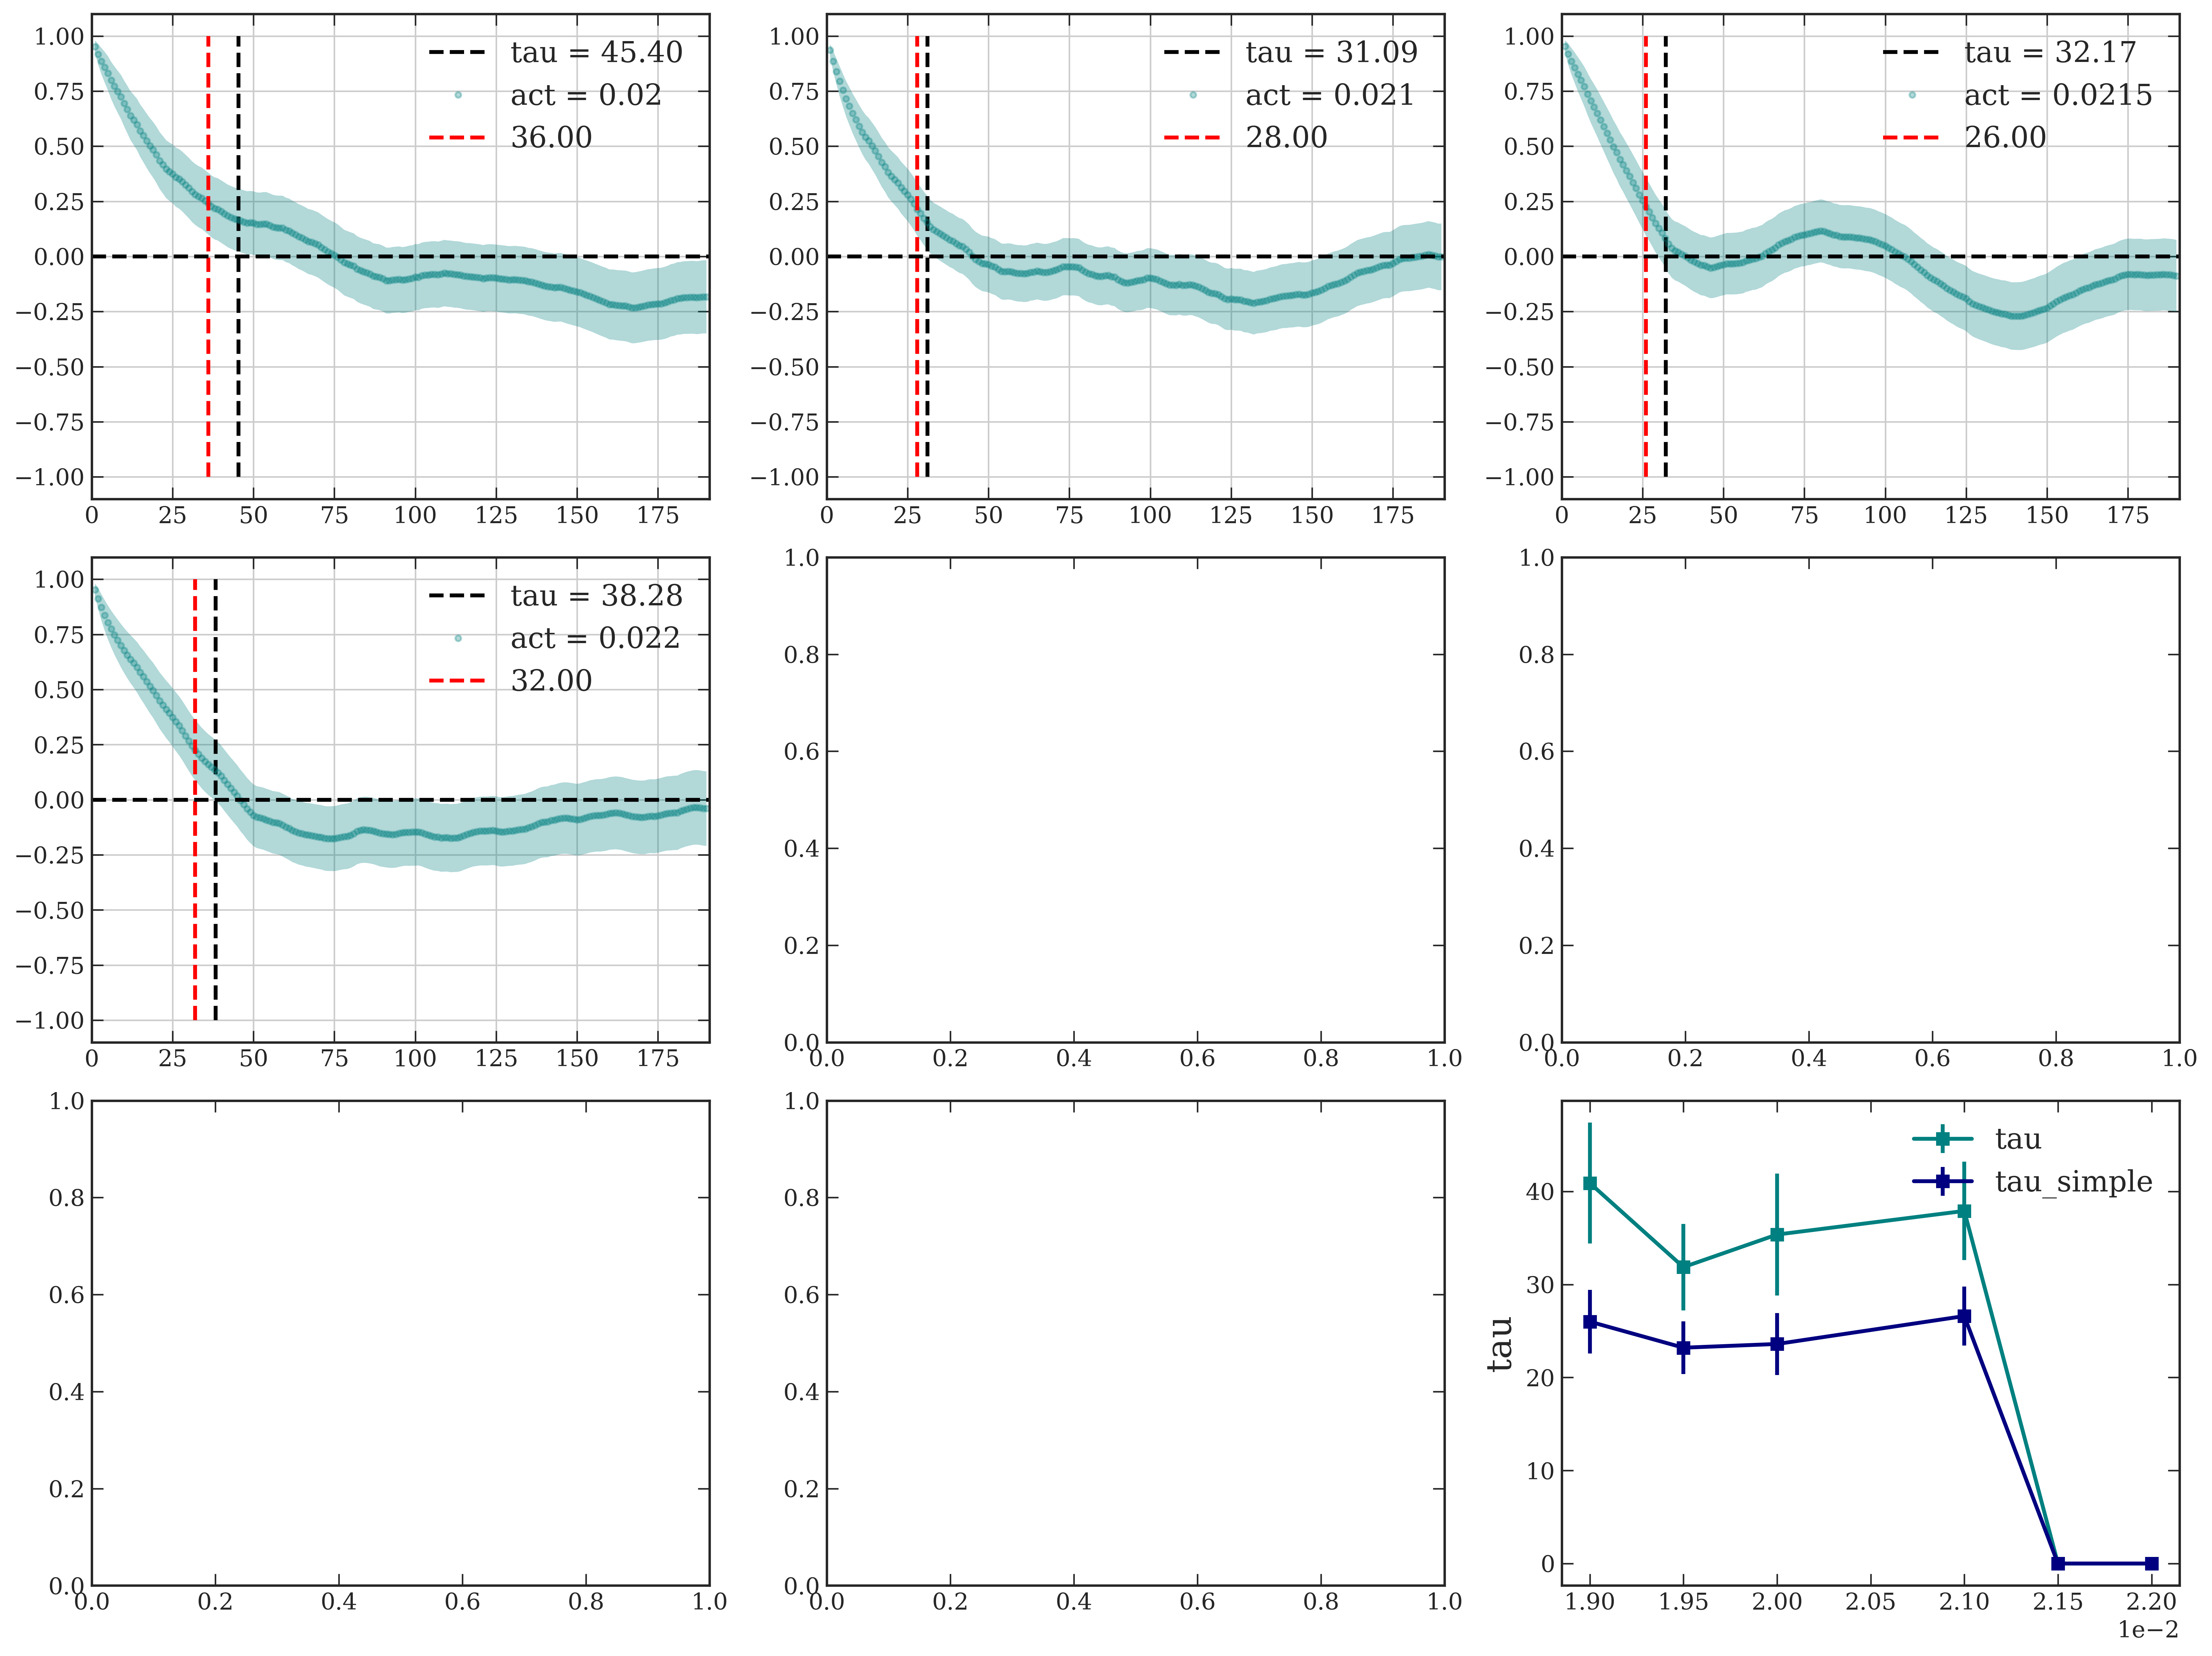

In [34]:
act_list = ad.act_list[N]
Nexp = ad.Nexp[N]
ndist_arr = np.zeros((len(act_list), Nexp, 2)) 
neff_arr = np.zeros((len(act_list)))
neff_arr_simple = np.zeros((len(act_list))) 

max_lag = None
alpha = 1 - 0.3413 * 2
threshold_eff_sample = 0
simple_threshold = 0.1

nrows = len(act_list) // 3 + 1 #if len(act_list) % 3 != 0 else len(act_list) // 3
fig, ax = plt.subplots(ncols = 3, nrows = nrows, figsize=(16, 4*nrows))
ax = ax.flatten()

def fit_exp(t, tau, beta):
                    return beta * np.exp(- t / tau)

param_guess = np.array([0.9, 30])
fit_string = r'$y = \beta e^{(-t/ \tau_0)}$'
Nparams = len(param_guess)

for j, act in enumerate(act_list[2:]):
    act_idx = act_list.index(act)

    conv_idx = conv_list[act_idx]
    nf = def_arr.shape[0] - conv_idx
    nlags=190# int(nf / 2)  
    conv_idx=150
    frames = np.arange(nlags +1)
    acf_arr, confint_arr = calc_acf_for_arr(def_arr[:, act_idx, :], conv_idx = conv_idx, nlags = nlags, alpha = alpha)

    confint_arr_sym = np.abs(confint_arr[:,1,:] - confint_arr[:,0,:]) / 2

    acf_avg, confint_avg = calc_weighted_mean(acf_arr[-(nlags + 1):,:], confint_arr_sym[-(nlags + 1):,:])
    Neff_av, tau_av, tau_simple_av = estimate_effective_sample_size(acf_avg, confint_avg, max_lag_threshold=threshold_eff_sample, max_lag=max_lag,)

    if 0:
        param_guess = np.array([0.9, tau_simple_av])
        x = frames[1:tau_simple_av]
        y = acf_avg[1:tau_simple_av]
        yerr = confint_avg[1:tau_simple_av]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
            fit = do_chi2_fit(fit_exp, x, y, yerr, param_guess, verbose = True)

        print(fit.values)
        ax[j].plot(x, fit_exp(x, *fit.values), label = fit_string)

   # print(tau_av, tau_simple_av)

    ax[j].vlines(tau_av, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau_av:.2f}')
    ax[j].plot(frames, acf_avg, '.', alpha=.3, label = f'act = {act}')  
    ax[j].fill_between(frames, acf_avg - confint_avg, acf_avg + confint_avg, alpha=.3)
    ax[j].vlines(tau_simple_av, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(tau_simple_av))

    ax[j].hlines(0, 0, len(frames), color='black', linestyles='dashed') 
    ax[j].set_xlim(0, len(frames))
    ax[j].grid(True)
    ax[j].legend();
   # ax[j].set_yscale('log') 

    for k in range(Nexp):

        acf_vals = acf_arr[- (nlags + 1):,k]
        confint_vals = confint_arr[- (nlags + 1):,:,k]

        Neff, tau, tau_simple = estimate_effective_sample_size(acf_vals, acf_err_vals=None,\
                                                    confint_vals =confint_vals, max_lag=max_lag, 
                                                    max_lag_threshold=threshold_eff_sample,
                                                    simple_threshold = simple_threshold)

        ndist_arr[j, k] = [tau, tau_simple]

    neff_arr[j] = np.nansum(nf / ndist_arr[j,:,0])
    neff_arr_simple[j] = np.nansum(nf / ndist_arr[j,:,1])

ax[-1].errorbar(act_list, np.nanmean(ndist_arr[:,:,0], axis=1), np.nanstd(ndist_arr[:,:,0], axis=1, ddof = 1) / np.sqrt(Nexp), marker='s', label='tau')
ax[-1].errorbar(act_list, np.nanmean(ndist_arr[:,:,1], axis=1), np.nanstd(ndist_arr[:,:,1], axis=1, ddof = 1) / np.sqrt(Nexp), marker='s', label='tau_simple')
#ax[-1].plot(act_list, ndist_arr[:,0,1], 'o-', label='tau_simple')
#ax[-1].set_xlabel('activity')
ax[-1].set_ylabel('tau')
ax[-1].legend()

print(neff_arr)
print(neff_arr_simple)

In [45]:
print(ndist_arr[:,:,0])

[[160.94843535 317.38201976 415.26973694 265.02087123   3.38793311
  341.94408214 310.98475368          nan 262.19279231          nan]
 [         nan  95.4271254  139.60414648 128.17319737 132.87856118
   73.75958471 132.71771429 115.07799117   1.          84.37932143]
 [123.44344816 110.48106192  85.29546013 104.57314277 171.64384131
  216.74158806 203.51926384 186.29770434  24.72718983 175.32242877]
 [264.15344199  85.28221679 148.32480325 281.84062794 305.01714888
  215.75038627 150.34327627 284.2471171  253.09322252  77.01607744]
 [122.46136473 295.2633066  175.28811168 265.18563936 178.20043504
  108.57748211 117.11828167 218.36118398 273.21279649 184.79776994]
 [260.38335908 319.99267863 430.4110594  213.52419504 251.26013257
  418.33200179 254.73050658 158.93459619 135.63946009 387.62050234]]


In [ ]:
ad.plot_defects_per_exp(Ndataset=-1, act_idx_bounds=[0, None])

In [ ]:
act = 0.020
act_idx = act_list.index(act)
alpha = 1 - 0.3413 * 2

conv_idx = conv_list[act_idx]
nf = def_arr.shape[0] - conv_idx
nlags= int(nf / 2)  
acf_arr, confint_arr = calc_acf_for_arr(def_arr[:, act_idx, :], conv_idx = conv_idx, nlags = nlags, alpha = alpha)
#acf_arr, confint, qstat, pvals = acf(def_arr[conv_list[act_idx]:,act_idx,0], nlags=500, qstat=True, alpha=0.05)


fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 16))
ax = ax.flatten()
threshold = .1 #0#.1
threshold_eff_sample = 0 #0.1
use_abs_sum = False
tau_arr = np.zeros(acf_arr.shape[-1])
max_lag = None # min(nlags, 1000)

for i, axx in enumerate(ax):
    if i < acf_arr.shape[-1]:

        frames = np.arange(nlags +1)
        acf_vals = acf_arr[- (nlags + 1):,i]
        confint_vals = confint_arr[- (nlags + 1):,:,i]
        # find max_lag as when acf is below threshold
      #  max_lag = np.where(acf_vals < threshold)[0][0]
        Neff, tau, first_frame_confint_zero = estimate_effective_sample_size(acf_vals, acf_err_vals=None,\
                                                    confint_vals =confint_vals, max_lag=max_lag, 
                                                    use_abs_sum=use_abs_sum,
                                                    max_lag_threshold=threshold_eff_sample
                                                    )
      #  first_frame_confint_zero = np.where(confint_vals[:,0] < np.abs(threshold))[0][0]
        tau_arr[i] = tau

        axx.plot(frames, acf_vals, '.', alpha=.3)
        axx.fill_between(frames, confint_vals[:,0], confint_vals[:,1], alpha=.3)
        
        axx.vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
        axx.vlines(first_frame_confint_zero, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero))
        axx.hlines(0, 0, len(frames), color='black', linestyles='dashed')
        axx.set_xlim(0, len(frames))

        axx.grid(True)
        axx.legend();

# now results for average acf.
# first calculate symmetric confint
confint_arr_sym = np.abs(confint_arr[:,1,:] - confint_arr[:,0,:]) / 2

acf_avg, confint_avg = calc_weighted_mean(acf_arr[-(nlags + 1):,:], confint_arr_sym[-(nlags + 1):,:])
#max_lag = np.where(acf_avg < threshold)[0][0]
Neff, tau, first_frame_confint_zero_avg = estimate_effective_sample_size(acf_avg, confint_avg, max_lag_threshold=threshold_eff_sample, max_lag=max_lag, use_abs_sum=use_abs_sum)
#first_frame_confint_zero_avg = np.where(acf_avg - confint_avg < np.abs(threshold))[0][0]
ax[acf_arr.shape[-1]].vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
ax[acf_arr.shape[-1]].plot(frames, acf_avg, '.', alpha=.3)  
ax[acf_arr.shape[-1]].fill_between(frames, acf_avg - confint_avg, acf_avg + confint_avg, alpha=.3)
ax[acf_arr.shape[-1]].vlines(first_frame_confint_zero_avg, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero_avg))

ax[acf_arr.shape[-1]].hlines(0, 0, len(frames), color='black', linestyles='dashed') 
ax[acf_arr.shape[-1]].set_xlim(0, len(frames))
ax[acf_arr.shape[-1]].grid(True)
ax[acf_arr.shape[-1]].legend();


ind_samp_tot = (nf / tau_arr).sum()

print(f'ind_samp_tot = {ind_samp_tot:.2f}')

print('ind samples mean acf: ', (len(tau_arr) * nf / tau).sum())  

# finally, calc acf of mean 
def_arr_av = np.nanmean(def_arr[:nf, act_idx, :], axis = -1)
def_arr_std = np.nanstd(def_arr[:nf, act_idx, :], axis = -1, ddof=1) / np.sqrt(def_arr.shape[-1])
#acf_arr_av, confint_arr_av = calc_acf_for_arr(def_arr_av[:, None], conv_idx = conv_idx, nlags = nlags, alpha = alpha)
ac, conf = acf(def_arr_av[:nf], nlags = nlags, alpha = alpha)

#first_frame_confint_zero_av = np.where(conf[:,0] < np.abs(threshold))[0][0]
#max_lag = np.where(ac < threshold)[0][0]
Neff, tau, first_frame_confint_zero_av = estimate_effective_sample_size(ac, acf_err_vals=None, confint_vals =conf, max_lag=max_lag, 
                                           use_abs_sum=use_abs_sum, max_lag_threshold=threshold_eff_sample)#, max_lag=max_lag)
ax[-1].vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}') 
ax[-1].vlines(first_frame_confint_zero_av, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero_av))
ax[-1].plot(frames, ac, '.', alpha=.3)
ax[-1].fill_between(frames, conf[:,0], conf[:,1], alpha=.3)
ax[-1].hlines(0, 0, len(frames), color='black', linestyles='dashed')
ax[-1].set_xlim(0, len(frames))
ax[-1].grid(True)
ax[-1].legend();

print('ind samp acf of mean: ', (len(tau_arr) * nf / tau).sum())  

In [ ]:

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()
threshold = .1
use_abs_sum = False
tau_arr = np.zeros(acf_arr.shape[-1])
max_lag = None# min(nlags, 1000)

for i, axx in enumerate(ax):
    if i < acf_arr.shape[-1]:

        frames = np.arange(nlags +1)
        acf_vals = acf_arr[- (nlags + 1):,i]
        confint_vals = confint_arr[- (nlags + 1):,:,i]
        # find max_lag as when acf is below threshold
      #  max_lag = np.where(acf_vals < threshold)[0][0]
        Neff, tau = estimate_effective_sample_size(acf_vals, acf_err_vals=None,\
                                                    confint_vals =confint_vals, max_lag=max_lag, use_abs_sum=use_abs_sum)
        first_frame_confint_zero = np.where(confint_vals[:,0] < threshold)[0][0]
        tau_arr[i] = tau

        axx.plot(frames, acf_vals, '.', alpha=.3)
        axx.fill_between(frames, confint_vals[:,0], confint_vals[:,1], alpha=.3)
        
        axx.vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
        axx.vlines(first_frame_confint_zero, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero))
        axx.hlines(0, 0, len(frames), color='black', linestyles='dashed')
        axx.set_xlim(0, len(frames))

        axx.grid(True)
        axx.legend();

# now results for average acf.
# first calculate symmetric confint
confint_arr_sym = np.abs(confint_arr[:,1,:] - confint_arr[:,0,:]) / 2

acf_avg, confint_avg = calc_weighted_mean(acf_arr[-(nlags + 1):,:], confint_arr_sym[-(nlags + 1):,:])
#max_lag = np.where(acf_avg < threshold)[0][0]
Neff, tau = estimate_effective_sample_size(acf_avg, confint_avg, threshold=0, max_lag=max_lag, use_abs_sum=use_abs_sum)
first_frame_confint_zero_avg = np.where(acf_avg - confint_avg < threshold)[0][0]
ax[acf_arr.shape[-1]].vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
ax[acf_arr.shape[-1]].plot(frames, acf_avg, '.', alpha=.3)  
ax[acf_arr.shape[-1]].fill_between(frames, acf_avg - confint_avg, acf_avg + confint_avg, alpha=.3)
ax[acf_arr.shape[-1]].vlines(first_frame_confint_zero_avg, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero_avg))

ax[acf_arr.shape[-1]].hlines(0, 0, len(frames), color='black', linestyles='dashed') 
ax[acf_arr.shape[-1]].set_xlim(0, len(frames))
ax[acf_arr.shape[-1]].grid(True)
ax[acf_arr.shape[-1]].legend();


ind_samp_tot = (1500 / tau_arr).sum()

print(f'ind_samp_tot = {ind_samp_tot:.2f}')

print('ind samples mean acf: ', (len(tau_arr) * 1500 / tau).sum())  

# finally, calc acf of mean 
def_arr_av = np.nanmean(def_arr[:nf, act_idx, :], axis = -1)
def_arr_std = np.nanstd(def_arr[:nf, act_idx, :], axis = -1, ddof=1) / np.sqrt(def_arr.shape[-1])
#acf_arr_av, confint_arr_av = calc_acf_for_arr(def_arr_av[:, None], conv_idx = conv_idx, nlags = nlags, alpha = alpha)
ac, conf = acf(def_arr_av[:nf], nlags = nlags, alpha = alpha)

first_frame_confint_zero_av = np.where(conf[:,0] < threshold)[0][0]
#max_lag = np.where(ac < threshold)[0][0]
Neff, tau = estimate_effective_sample_size(ac, acf_err_vals=None, confint_vals =conf, max_lag=max_lag, use_abs_sum=use_abs_sum)#, max_lag=max_lag)
ax[-1].vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}') 
ax[-1].vlines(first_frame_confint_zero_av, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero_av))
ax[-1].plot(frames, ac, '.', alpha=.3)
ax[-1].fill_between(frames, conf[:,0], conf[:,1], alpha=.3)
ax[-1].hlines(0, 0, len(frames), color='black', linestyles='dashed')
ax[-1].set_xlim(0, len(frames))
ax[-1].grid(True)
ax[-1].legend();

print('ind samp acf of mean: ', (len(tau_arr) * 1500 / tau).sum())  


In [ ]:

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()

nlags = 350


for i, axx in enumerate(ax):
    if i < acf_arr.shape[-1]:

        frames = np.arange(nlags +1)
        acf_vals = acf_arr[- (nlags + 1):,i]
        confint_vals = confint_arr[- (nlags + 1):,:,i]
        Neff, tau = estimate_effective_sample_size(acf_vals, acf_err_vals=None, confint_vals =confint_vals, threshold=0.1,)

        first_frame_confint_zero = np.where(confint_vals[:,0] < 0)[0][0]

        axx.plot(frames, acf_vals, '.', alpha=.3)
        axx.fill_between(frames, confint_vals[:,0], confint_vals[:,1], alpha=.3)
        
        axx.vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
        axx.vlines(first_frame_confint_zero, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero))
        axx.hlines(0, 0, len(acf_arr[conv_list[act_idx]:,i]), color='black', linestyles='dashed')
        axx.set_xlim(0, len(acf_arr[conv_list[act_idx]:,i]))

        axx.grid(True)
        axx.legend();

# now results for average acf.
# first calculate symmetric confint
confint_arr_sym = np.abs(confint_arr[:,1,:] - confint_arr[:,0,:]) / 2

acf_avg, confint_avg = calc_weighted_mean(acf_arr[-(nlags + 1):,:], confint_arr_sym[-(nlags + 1):,:])
Neff, tau = estimate_effective_sample_size(acf_avg, confint_avg, threshold=0.1,)
first_frame_confint_zero_avg = np.where(acf_avg - confint_avg < 0)[0][0]
ax[acf_arr.shape[-1]].vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
ax[acf_arr.shape[-1]].plot(frames, acf_avg, '.', alpha=.3)  
ax[acf_arr.shape[-1]].fill_between(frames, acf_avg - confint_avg, acf_avg + confint_avg, alpha=.3)
ax[acf_arr.shape[-1]].vlines(first_frame_confint_zero_avg, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero_avg))

ax[acf_arr.shape[-1]].hlines(0, 0, len(frames), color='black', linestyles='dashed') 
ax[acf_arr.shape[-1]].set_xlim(0, len(frames))
ax[acf_arr.shape[-1]].grid(True)
ax[acf_arr.shape[-1]].legend();

In [65]:
ac, conf = acf(def_arr[-200:, 6, 10], nlags = 200, alpha = .05)

In [89]:
acf_arr[-1,:]

array([-9.62541885e-02,  6.09738529e-03,  8.46020759e-02,  6.63059910e-02,
        5.30191686e-02, -2.55015496e-01, -4.63965623e-02,  5.49795921e-02,
       -2.64154382e-05, -1.44718450e-01])

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()

for i, axx in enumerate(ax):
    if i < def_arr.shape[0]:
        plot_acf(def_arr[conv_list[act_idx]:,act_idx,i], ax=axx, fft=True, lags=200, alpha = 0.05, use_vlines=True, title = '', label =f'exp = {i}',);
        axx.legend();

# 

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()

for i, act in enumerate(act_list):
    plot_acf(np.nanmean(def_arr[conv_list[i]:,i,:], axis=-1), ax=ax[i], fft=True, lags=350, alpha = 0.05, use_vlines=True, title = '', label =f'act = {act}',);
    ax[i].legend();

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()

for i, act in enumerate(act_list):
    plot_acf(np.nanmean(def_arr[conv_list[i]:,i,:], axis=-1), ax=ax[i], fft=True, lags=350, alpha = 0.05, use_vlines=True, title = '', label =f'act = {act}',);
    ax[i].legend();

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()

for i, act in enumerate(act_list):
    plot_acf(np.nanmean(def_arr[conv_list[i]:,i,:], axis=-1), ax=ax[i], fft=True, lags=200, alpha = 0.05, use_vlines=True, title = '', label =f'act = {act}',);
    ax[i].legend();


In [ ]:
def calc_autocorr(x, axis = 0, conv_list = None):

    conv_list = x.shape[1] * [0] if conv_list is None else conv_list

    x_av = np.nan * np.zeros(x.shape[1])
    auto_corr = np.nan * np.zeros_like(x)

    for i in range(x.shape[1]):
        x_av[i] = np.nanmean(x[conv_list[i]:,i])
        X = x[conv_list[i]:,i] - x_av[i]
        auto_corr[:,i] = np.correlate(X, X, mode='full') / np.sum(X[:]**2)

    X = (x - x_av) 

  # result = np.correlate(x - av, x - av, mode='full') / var ## np.nansum((x)**2)
    result = np.correlate(X, X, mode='full') / np.sum(X[:]**2)
    return result[result.size // 2:] #/ normalization

def calc_autocorr(x,conv_list = None):

    conv_list = x.shape[1] * [0] if conv_list is None else conv_list

    x_av = np.nan * np.zeros(x.shape[1])
    auto_corr = np.nan * np.zeros_like(x)

    for i in range(x.shape[1]):
        x_av[i] = np.nanmean(x[conv_list[i]:,i])
        X = x[conv_list[i]:,i] - x_av[i]
        X_corr = np.correlate(X, X, mode='full') / np.sum(X[:]**2)
        X_corr = X_corr[X_corr.size // 2:]
        auto_corr[-X_corr.size:,i] = X_corr
    return auto_corr#[auto_corr.shape[0] // 2:] #/ normalization


In [ ]:
Ndataset_list = [0,-1] # [0,1, 2]
act_idx_bounds_list = [[6,None], [0,None]] #] [[11,-3], [-2,None], [0,None]]
fig, ax = plt.subplots(ncols=2, figsize=(16,12))
ax = ax.flatten()
for k, Ndataset in enumerate(Ndataset_list):
    defect_arr = ad.get_arrays_full(Ndataset=Ndataset)[0]
    conv_list = ad.conv_list[Ndataset]
  #  conv_list = defect_arr.shape[1] * [0]
    act_list = ad.act_list[Ndataset]
    auto_corr = np.zeros_like(defect_arr)
    Ndist = np.zeros(defect_arr.shape[1])
    lag = 10
    for i in range(defect_arr.shape[-1]):
        auto_corr[:, :, i] = calc_autocorr(defect_arr[:,:,i], conv_list)#np.apply_along_axis(calc_autocorr, axis = 0, arr = defect_arr[:, :, i])

   # fig, ax = plt.subplots(ncols=2, figsize=(16,12))
   # ax = ax.flatten()
    auto_corr_mean = np.nanmean(auto_corr, axis = -1)
    auto_corr_std = np.nanstd(auto_corr, axis=-1) / np.sqrt(defect_arr.shape[-1])
    Ndist 
    i0 = 0
    for i, act in enumerate(act_list[act_idx_bounds_list[k][0]:act_idx_bounds_list[k][1]]):
        i += i0
        ax[0].errorbar(act, auto_corr_mean[conv_list[i] + lag,i], auto_corr_std[conv_list[i] + lag,i], fmt='o', label=f'act = {act}')
        ax[1].errorbar(range(defect_arr.shape[0]),auto_corr_mean[:,i], auto_corr_std[:,i], label=f'act = {act}',alpha=.3)
        Ndist[i] = (1+2*(auto_corr_mean[conv_list[i] + 1:,i]**2).sum(axis=0))
    ax[1].legend(ncol=2,fontsize=12)
    ax[0].legend(ncol=2,fontsize=12)
    #Ndist = (1+2*(auto_corr_mean[1:,:]**2).sum(axis=0))
    Ndist, defect_arr.shape[0] * defect_arr.shape[-1] / Ndist
ax[0].set_xscale('log') 
ax[1].set_xscale('log')

In [ ]:
Ndataset=-1
defect_arr = ad.get_arrays_full(Ndataset=Ndataset)[0]
conv_list = ad.conv_list[Ndataset]
conv_list = defect_arr.shape[1] * [0]
act_list = ad.act_list[Ndataset]
auto_corr = np.zeros_like(defect_arr)
Ndist = np.zeros(defect_arr.shape[1])
lag = 1
for i in range(defect_arr.shape[-1]):
    auto_corr[:, :, i] = calc_autocorr(defect_arr[:,:,i], conv_list)#np.apply_along_axis(calc_autocorr, axis = 0, arr = defect_arr[:, :, i])

fig, ax = plt.subplots(ncols=2, figsize=(16,12))
ax = ax.flatten()
auto_corr_mean = np.nanmean(auto_corr, axis = -1)
auto_corr_std = np.nanstd(auto_corr, axis=-1) / np.sqrt(defect_arr.shape[-1])
Ndist 
i0 = 0
for i, act in enumerate(act_list[i0:]):
    i += i0
    ax[0].errorbar(act, auto_corr_mean[conv_list[i] + lag,i], auto_corr_std[conv_list[i] + lag,i], fmt='o', label=f'act = {act}')
    ax[1].errorbar(range(defect_arr.shape[0]),auto_corr_mean[:,i], auto_corr_std[:,i], label=f'act = {act}',alpha=.3)
    Ndist[i] = (1+2*(auto_corr_mean[conv_list[i] + 1:,i]**2).sum(axis=0))
ax[1].legend(ncol=2,fontsize=12)
ax[0].legend(ncol=2,fontsize=12)
#Ndist = (1+2*(auto_corr_mean[1:,:]**2).sum(axis=0))
Ndist, defect_arr.shape[0] * defect_arr.shape[-1] / Ndist

In [ ]:
Ndataset=-1
defect_arr = ad.get_arrays_full(Ndataset=Ndataset)[0]

act_list = ad.act_list[Ndataset]
auto_corr = np.zeros_like(defect_arr)
lag = 60
for i in range(defect_arr.shape[-1]):
    auto_corr[:, :, i] = np.apply_along_axis(calc_autocorr, axis = 0, arr = defect_arr[:, :, i])

fig, ax = plt.subplots(ncols=2, figsize=(16,12))
ax = ax.flatten()
auto_corr_mean = np.nanmean(auto_corr, axis = -1)
auto_corr_std = np.nanstd(auto_corr, axis=-1) / np.sqrt(defect_arr.shape[-1])
ax[0].errorbar(act_list, auto_corr_mean[lag], auto_corr_std[lag], fmt='.-')
for i, act in enumerate(act_list):
    ax[1].errorbar(range(defect_arr.shape[0]),auto_corr_mean[:,i], auto_corr_std[:,i], label=f'act = {act}',alpha=.3)
ax[1].legend(ncol=2,fontsize=12)
ax[0].legend(ncol=2,fontsize=12)
Ndist = (1+2*(auto_corr_mean[1:,:]**2).sum(axis=0))
Ndist, defect_arr.shape[0] * defect_arr.shape[-1] / Ndist

In [ ]:
# extracting only the temperature values
values = pd.DataFrame(def_arr_series.values)
 
# using shift function to shift the values.
dataframe = pd.concat([values.shift(3), values.shift(2),
                       values.shift(1), values], axis=1)
# naming the columns
dataframe.columns = ['t', 't+1', 't+2', 't+3']
 
# using corr() function to compute the correlation
result = dataframe.corr()
 
from statsmodels.tsa.stattools import acf 
from statsmodels.graphics.tsaplots import plot_acf
act_idx = -2
acf_arr, confint, qstat, pvals = acf(def_arr[conv_list[act_idx]:,act_idx,0], nlags=500, qstat=True, alpha=0.05)

print(result)